In [1]:
import sys
import os
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))
from os import walk
import shutil
import json
from pathlib import Path
import talib
import sqlite3 as sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
from mplfinance.original_flavor import candlestick_ohlc
from util.util import get_random_header, remove_line, remove_first_end_spaces, get_ucodes
pd.options.mode.chained_assignment = None

In [2]:
path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
print(path_sqlite)
path_img = os.path.join(path_root, 'data', 'img')
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()
conn.row_factory = lambda cursor, row: row[0]

ucodes = []
for k, v in get_ucodes().items():
    for v1 in v:
        if '.HK' in v1:
            ucodes.append(v1.replace('.HK', '').zfill(5))
        else:
            ucodes.append(v1.lower().replace('.', ''))

# ucodes = ['09988']
data1 = {}
for ucode in ucodes:
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC LIMIT 365*20) AS t 
                            ORDER BY t.stime """.format(ucode)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data1[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
conn.close()

D:\PycharmProjects\scrapy-001\data\aastock\sqlite\hk-marketwatch.db


In [3]:
no_days = 5
val = 2

data2 = {}
for ucode, _df in data1.items():
    try:
        df = _df.copy(deep=True)
        df.fillna(0, inplace=True)
        #
        highs = np.array(df['high'], dtype='float')
        lows = np.array(df['low'], dtype='float')
        opens = np.array(df['open'], dtype='float')
        closes = np.array(df['last'], dtype='float')
        vols = np.array(df['vol'], dtype='float')
        df['vol-ema5']= talib.EMA(vols, timeperiod=5)
        df['sma100']= talib.SMA(closes, timeperiod=100)
        data1[ucode]['sma100']= talib.SMA(closes, timeperiod=100)
        #
        df = df.tail(no_days)
        mask = (df['vol'] >= df['vol-ema5']*val)
        df2 = df.loc[mask]
        df2.drop(columns=['lot', 'high', 'low', 'open', 'vol', 'vol-ema5'], inplace=True)
        if df2.shape[0] > 0:
            df2['signal-outflow'] = np.nan
            df2['signal-inflow'] = np.nan
            df2['signal-outflow'].loc[(df2['last']>df2['sma100'])] = df['sma100']
            df2['signal-inflow'].loc[(df2['last']<df2['sma100'])] = df['sma100']
            data2[ucode] = pd.merge(data1[ucode], df2, how="outer")
    except:
        print('err: '+ucode)

d:\pycharmprojects\scrapy-001\venv\lib\site-packages\mplfinance\plotting.py:493: RuntimeWarning: All-NaN slice encountered
  vymin = 0.3 * np.nanmin(volumes)
d:\pycharmprojects\scrapy-001\venv\lib\site-packages\mplfinance\plotting.py:494: RuntimeWarning: All-NaN slice encountered
  vymax = 1.1 * np.nanmax(volumes)


nasi
Axis limits cannot be NaN or Inf
draw: ssec D:\PycharmProjects\scrapy-001\data\algo\ssec.png
draw: csi300 D:\PycharmProjects\scrapy-001\data\algo\csi300.png
draw: 00857 D:\PycharmProjects\scrapy-001\data\algo\00857.png
draw: 02009 D:\PycharmProjects\scrapy-001\data\algo\02009.png
draw: 01787 D:\PycharmProjects\scrapy-001\data\algo\01787.png
draw: 00914 D:\PycharmProjects\scrapy-001\data\algo\00914.png
draw: 03323 D:\PycharmProjects\scrapy-001\data\algo\03323.png
00691
O,H,L,C must have the same amount of missing data!
draw: 02868 D:\PycharmProjects\scrapy-001\data\algo\02868.png
draw: 06060 D:\PycharmProjects\scrapy-001\data\algo\06060.png
draw: 06862 D:\PycharmProjects\scrapy-001\data\algo\06862.png
draw: 01896 D:\PycharmProjects\scrapy-001\data\algo\01896.png
draw: 00780 D:\PycharmProjects\scrapy-001\data\algo\00780.png
00169
O,H,L,C must have the same amount of missing data!
draw: 00493 D:\PycharmProjects\scrapy-001\data\algo\00493.png
draw: 06186 D:\PycharmProjects\scrapy-001\

d:\pycharmprojects\scrapy-001\venv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\pycharmprojects\scrapy-001\venv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


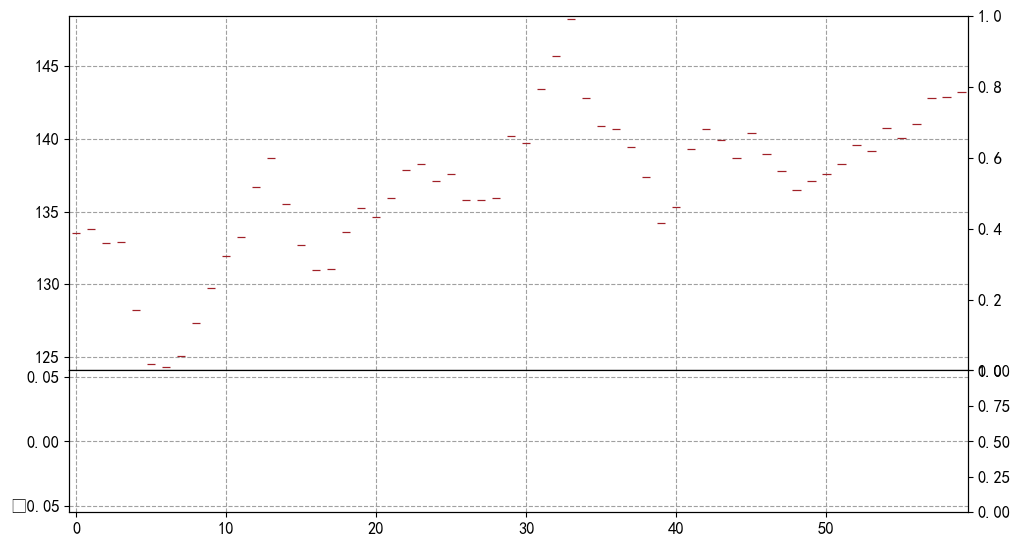

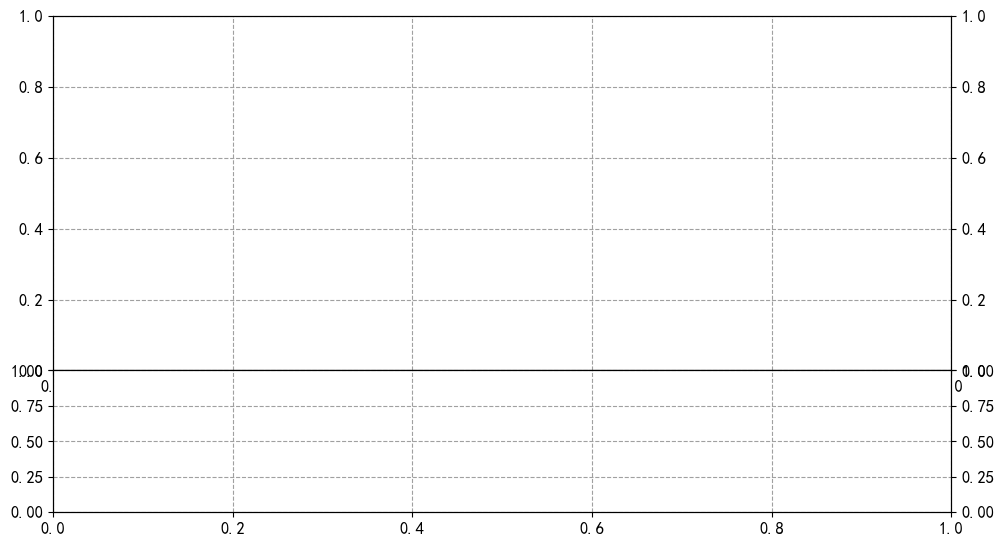

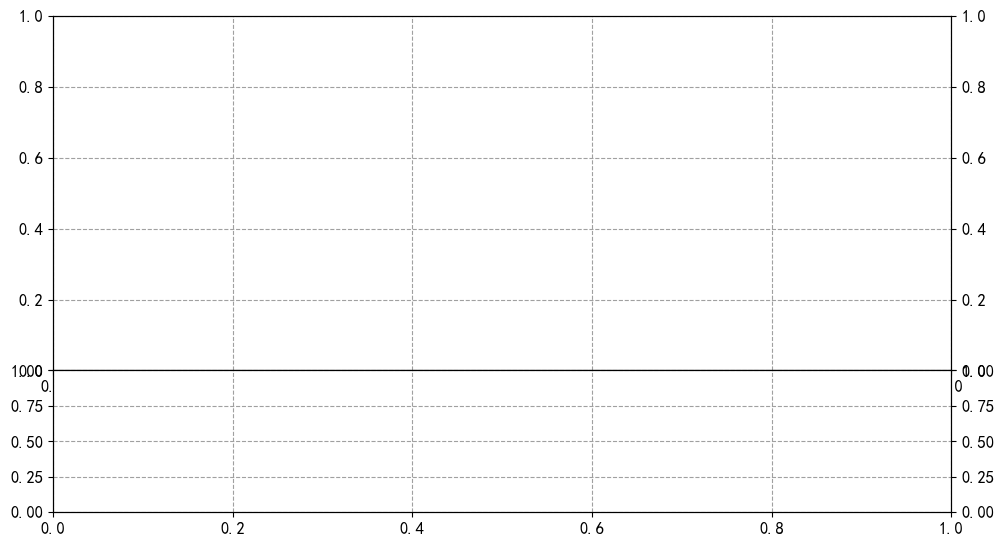

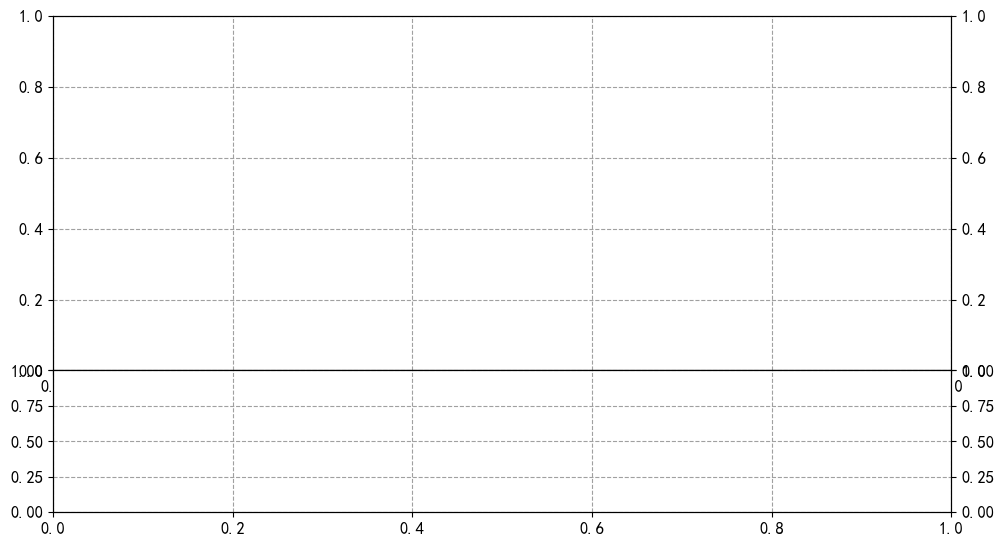

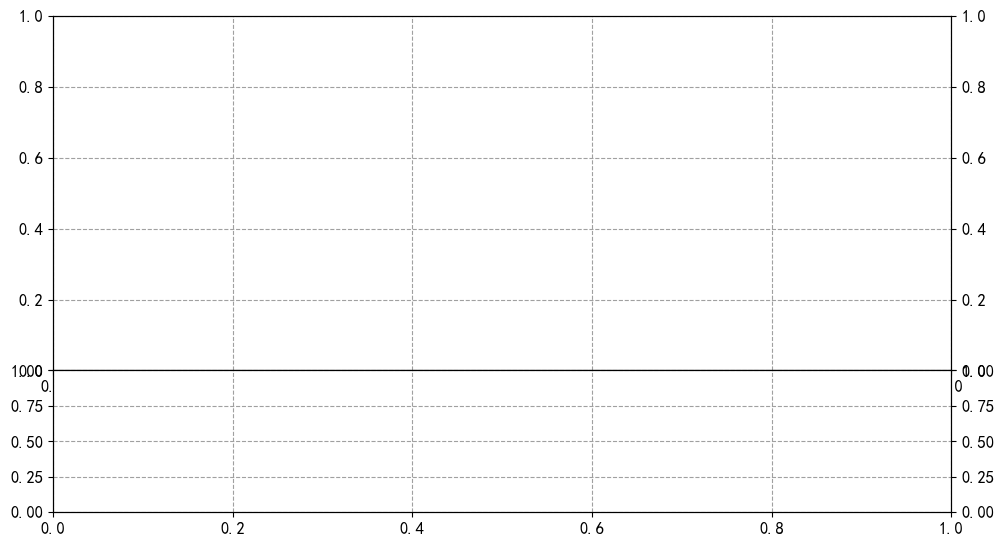

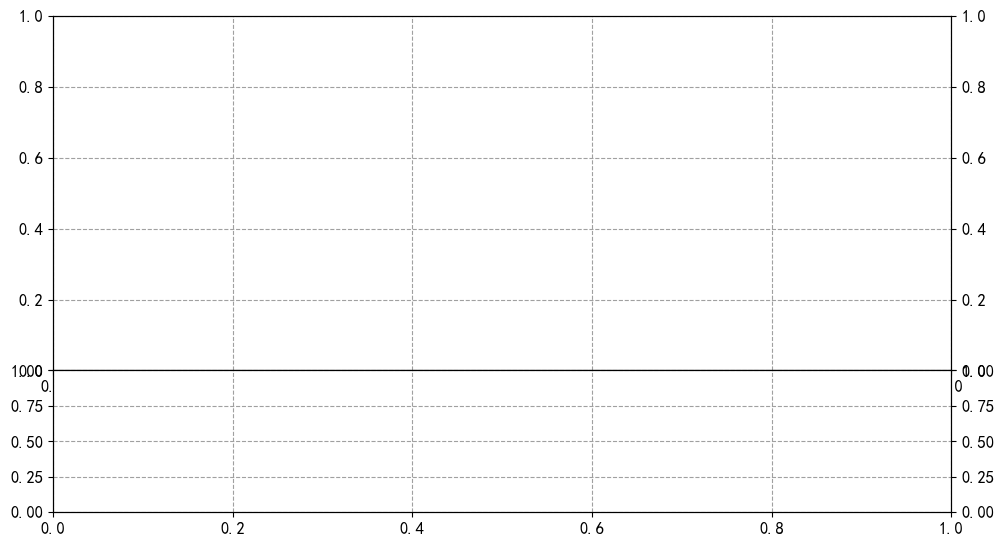

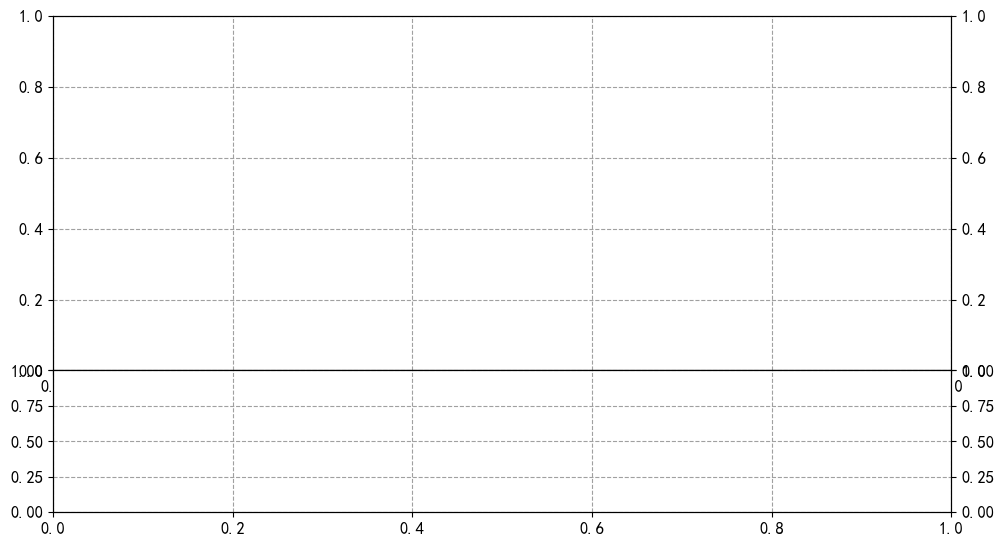

In [4]:
no_days = 60
path_img = os.path.join(path_root, 'data', 'algo')
path_img2 = os.path.join(path_root2, 'data', 'algo')

if os.path.exists(path_img):
    path_json = os.path.join(path_img, 'data.json')
    for (dirpath, dirnames, filenames) in walk(path_img):
        for f in filenames:
            os.remove(os.path.join(path_img, f))

if os.path.exists(path_img2):
    path_json = os.path.join(path_img2, 'data.json')
    for (dirpath, dirnames, filenames) in walk(path_img2):
        for f in filenames:
            os.remove(os.path.join(path_img2, f))

data_json = {}
for k, _df in data2.items():
    df = _df.copy(deep=True)
    if df.shape[0] < no_days:
        df = df.iloc[1:]
    df.columns = ['code', 'lot', 'nmll', 'sdate', 'High', 'Low', 'Open', 'Close', 'Volume', 'sma100', 'signal-outflow', 'signal-inflow']
    df["Volume"] = pd.to_numeric(df["Volume"])
    df.index = pd.to_datetime(df.sdate)
    df = df.tail(no_days)
    prop = fm.FontProperties(fname='D:/PycharmProjects/quant_trading_1/msjh.ttf')
    style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size':12, 'font.family' : 'SimHei'}, gridaxis='both')
    title = _df['nmll'].iloc[1]

    if os.path.exists(path_img):
        path_save = os.path.join(path_img, k+'.png')
    else:
        path_save = os.path.join(path_img2, k+'.png')

    if os.path.exists(path_save):
        os.remove(path_save)
        print('del: '+path_save)

    try:
        apds = [mpf.make_addplot(df['sma100'],panel=0,color='orange',linestyle='dotted')]
        if df['signal-outflow'].notna().values.any():
            apds.append(mpf.make_addplot(df['signal-outflow'],type='scatter',markersize=100,marker='^',panel=0))
        if df['signal-inflow'].notna().values.any():
            apds.append(mpf.make_addplot(df['signal-inflow'],type='scatter',markersize=100,marker='v',panel=0))
            
        fig, axs = mpf.plot(df, type='candle', addplot=apds, style=style, ylabel='', ylabel_lower='', title=title,
                            volume=True, figratio=(18,10), figscale=1, xrotation=0, datetime_format="%Y-%m-%d", show_nontrading=False,
                            tight_layout=True, scale_width_adjustment=dict(volume=0.6,candle=1), returnfig=True, savefig=path_save)
        data_json[k] = df['nmll'].iloc[1]
        print('draw: '+k+' '+path_save)
    except Exception as e:
        print(k)
        print(e)

In [5]:
if os.path.exists(path_json):
    os.remove(path_json)
    print('del: '+path_json)
with open(path_json, 'w', encoding='utf8') as outfile:
    json.dump(data_json, outfile, ensure_ascii=False)